# TrustPilot Scraper | Results Analysis

This notebook conducts some data cleaning, filtering and analysis on the results of the data scraped by the TrustPilot scraper developed in the previous notebook. 

## 0.0 Import Libraries

In [1]:
# Data manipulation & stats
import pandas as pd
import numpy as np
import re
import csv

# Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Standard libraries
import os
import datetime
import time
from tqdm import tqdm
import random

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.rcParams['figure.figsize'] = [10, 6]

## 1.0 Setup Config

### 1.1 Local paths

In [2]:
notebooks_dir_path = os.getcwd()
repo_dir_path = notebooks_dir_path.replace("/notebooks", "")
data_dir_path = os.path.join(repo_dir_path, "data")

In [3]:
# Local data paths
category_dirs = os.listdir(data_dir_path)
category_dirs = [directory for directory in category_dirs if not directory.startswith(".")]
print(f"Categories scraped:")

# Category paths
category_dir_paths = [os.path.join(data_dir_path, directory) for directory in category_dirs]
category_df_paths = [os.path.join(directory, "companies_df_full.csv") for directory in category_dir_paths]
category_df_paths = [
    os.path.join(directory, "companies_df_full.csv") for directory in category_dir_paths \
    if os.path.exists(os.path.join(directory, "companies_df_full.csv"))
]

# Read in data
df_dict = {}
for category_df_path in category_df_paths:
    category_name = category_df_path.split("/")[7]
    print(category_name)
    
    # Read in df
    data = []
    
    with open(category_df_path, "r", encoding="utf-8") as file:
        reader = csv.reader(file)
    
        try:
            for row in reader:
                data.append(row)
        except csv.Error as e:
            print(f"Error reading CSV file: {e}")
    
    # Convert the list of lists (data) to a pandas DataFrame
    category_df = pd.DataFrame(data)

    category_df.columns = category_df.iloc[0]
    category_df = category_df[1:]  # Skip the first row since it's now the header
    
    df_dict[category_name] = category_df
    df_clean_path = os.path.join(data_dir_path, category_name, "clean_categories_data.csv")
    category_df.to_csv(df_clean_path)


Categories scraped:
home_garden
travel_vacation
animals_pets
beauty_wellbeing
events_entertainment
money_insurance
electronics_technology
food_beverages_tobacco
vehicles_transportation
shopping_fashion


## 2.0 Category data analysis

### 2.1 Data cleaning

In [4]:
# Dimensions for each raw category df
for key in df_dict.keys():
    print(f"{key}: {df_dict[key].shape}")

home_garden: (1280, 11)
travel_vacation: (20830, 11)
animals_pets: (6561, 11)
beauty_wellbeing: (9095, 11)
events_entertainment: (2971, 11)
money_insurance: (21048, 11)
electronics_technology: (32094, 11)
food_beverages_tobacco: (11041, 11)
vehicles_transportation: (23312, 11)
shopping_fashion: (30315, 11)


In [5]:
df = pd.DataFrame()

for df_sub_name in df_dict.keys():
    df_sub = df_dict[df_sub_name]
    df_sub["category"] = df_sub_name
    df = pd.concat(
        [df, df_sub],
        ignore_index=True
    )

In [6]:
print(f"{'-'*100}\nNumber of None records by column\n{'-'*100}\n{df.isnull().sum() / len(df)}")

----------------------------------------------------------------------------------------------------
Number of None records by column
----------------------------------------------------------------------------------------------------
0
company_name       0.000000
review_link        0.001608
company_score      0.003778
num_reviews        0.003778
categories_page    0.003778
address            0.003778
is_uk              0.003778
date               0.003778
score              0.003778
review             0.003778
reviews_page       0.005948
category           0.000000
dtype: float64


In [7]:
# Drop Null rows
df = df.dropna()

# Drop duplicates
df = df.drop_duplicates()

# Convert all int to columns
for col_int in ["company_score", "num_reviews", "categories_page", "score"]:
    df[col_int] = df[col_int].astype(float)

# Convert all str columns to lower
for col_str in ["company_name", "address", "review"]:
    df[f"{col_str}_clean"] = df[col_str].apply(lambda x: x.lower() if x is not None else "")
    
# Clean is_uk column
df["is_uk"] = df.groupby("company_name_clean")["address_clean"].transform(
    lambda x: any(("uk" in str(a) or "united kingdom" in str(a)) for a in x)
)
# Find most common address for each company - that isn't blank
most_common_address = df.groupby("company_name_clean")["address_clean"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
).reset_index()
most_common_address.columns = ["company_name_clean", "most_common_address_clean"]
most_common_address["most_common_address_clean"] = most_common_address["most_common_address_clean"].apply(
    lambda x: x if (x is not None and x != "") else "united kingdom"
)
# Merge and replace the most common address
df = pd.merge(df, most_common_address, on='company_name_clean', how='left')
df["address_clean"] = df["most_common_address_clean"]
df = df.drop("most_common_address_clean", axis=1)

# Detect keywords in reviews
keywords = ['whatsapp', 'whats app', 'whats app', 'message', 'texted', 'text', 'sms', 'messaged']
df["review_clean"] = df["review"].apply(lambda x: x.lower() if x is not None else "")
df["contains_keyword"] = df["review_clean"].str.contains('|'.join(map(re.escape, keywords)))

# Get number of reviews in df
num_reviews_in_df = pd.DataFrame(
    df.groupby("company_name_clean")["review"].count()
).rename(columns={"review": "num_reviews_in_df"})

df = pd.merge(
    df,
    num_reviews_in_df,
    on="company_name_clean",
    how="left"
)
df["pct_reviews_scraped"] = df["num_reviews_in_df"] / df["num_reviews"]

# Get pct of reviews that contain keyword
num_contains_keyword = pd.DataFrame(
    df.groupby("company_name_clean")["contains_keyword"].sum()
).rename(columns={"contains_keyword": "num_contains_keyword"})

df = pd.merge(
    df,
    num_contains_keyword,
    on="company_name_clean",
    how="left"
)
df["pct_contains_keyword"] = df["num_contains_keyword"] / df["num_reviews_in_df"]

df = df.loc[df.is_uk == True]

## Run sentiment analysis on review
#df["sentiment"] = df["review"].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
## Classify sentiments into positive, neutral, or negative
#df["sentiment_class"] = df["sentiment"].apply(lambda x: "positive" if x["compound"] >= 0.05 else ("negative" if x["compound"] <= -0.05 else "neutral"))

print(df.shape)
df.head()

(122168, 20)


,company_name,review_link,company_score,num_reviews,categories_page,address,is_uk,date,score,review,reviews_page,category,company_name_clean,address_clean,review_clean,contains_keyword,num_reviews_in_df,pct_reviews_scraped,num_contains_keyword,pct_contains_keyword
0,Secretgardeningclub,https://uk.trustpilot.com/review/www.secretgar...,2.2,1250.0,88.0,united kingdom,True,2023-11-20,1.0,I ordered on 15th October and was charged on 1...,1,home_garden,secretgardeningclub,united kingdom,i ordered on 15th october and was charged on 1...,False,720,0.576,39,0.054167
1,Secretgardeningclub,https://uk.trustpilot.com/review/www.secretgar...,2.2,1250.0,88.0,united kingdom,True,2023-11-17,1.0,Ordered bulbs on 13 October. It took until 01 ...,1,home_garden,secretgardeningclub,united kingdom,ordered bulbs on 13 october. it took until 01 ...,False,720,0.576,39,0.054167
2,Secretgardeningclub,https://uk.trustpilot.com/review/www.secretgar...,2.2,1250.0,88.0,united kingdom,True,2023-10-01,1.0,"Oh dear, used to be good. Ordered plants earli...",1,home_garden,secretgardeningclub,united kingdom,"oh dear, used to be good. ordered plants earli...",False,720,0.576,39,0.054167
3,Secretgardeningclub,https://uk.trustpilot.com/review/www.secretgar...,2.2,1250.0,88.0,united kingdom,True,2023-11-07,1.0,"Waste of time no correspondence, do not reply ...",1,home_garden,secretgardeningclub,united kingdom,"waste of time no correspondence, do not reply ...",False,720,0.576,39,0.054167
4,Secretgardeningclub,https://uk.trustpilot.com/review/www.secretgar...,2.2,1250.0,88.0,united kingdom,True,2023-10-04,2.0,Poor communication. Difficult to contact. Long...,1,home_garden,secretgardeningclub,united kingdom,poor communication. difficult to contact. long...,False,720,0.576,39,0.054167


### 2.2 Category stats

In [8]:
print(f"Number of companies: {df.company_name_clean.nunique()}")

Number of companies: 171


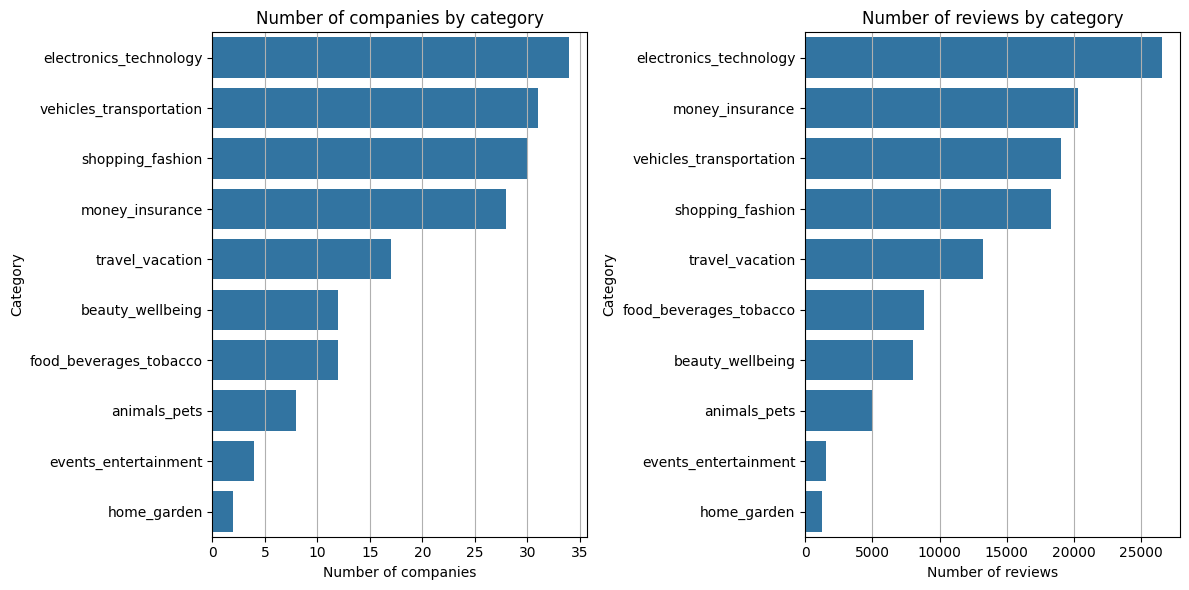

In [9]:
# Number of companies by category
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1 - Number of companies by category
sns.barplot(
    pd.DataFrame(
        df.groupby("category")["company_name_clean"].nunique()
    ).rename(columns={"company_name_clean": "num_companies"}).sort_values("num_companies", ascending=False),
    x="num_companies",
    y="category",
    ax=axes[0] 
)

axes[0].set_title("Number of companies by category")
axes[0].set_xlabel("Number of companies")
axes[0].set_ylabel("Category")
axes[0].grid(axis="x")

# Plot 2 - Number of reviews by category
sns.barplot(
    pd.DataFrame(
        df.groupby("category")["review"].count()
    ).rename(columns={"review": "num_reviews"}).sort_values("num_reviews", ascending=False),
    x="num_reviews",
    y="category",
    ax=axes[1]
)

axes[1].set_title("Number of reviews by category")
axes[1].set_xlabel("Number of reviews")
axes[1].set_ylabel("Category")
axes[1].grid(axis="x")

plt.tight_layout()
plt.show()

### 2.3 Keyword stats

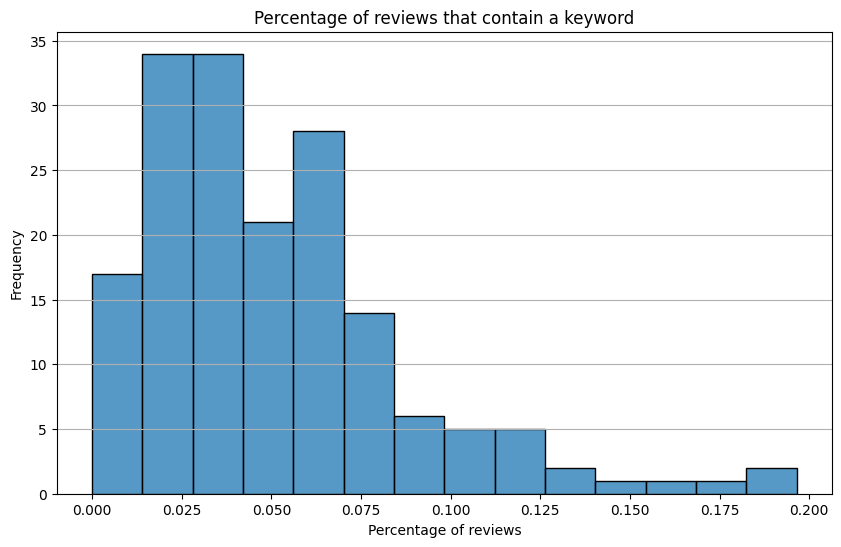

In [10]:
# Number of reviews that contain keyword
sns.histplot(
    df[["company_name_clean", "pct_contains_keyword"]].drop_duplicates(),
    x="pct_contains_keyword"
)

plt.title("Percentage of reviews that contain a keyword")
plt.xlabel("Percentage of reviews")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

### 2.4 Sentiment Analysis

In [ ]:
# Sentiment analysis on each review
df["sentiment"] = df["review"].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
# Classify sentiments into positive, neutral, or negative
df["sentiment_class"] = df["sentiment"].apply(lambda x: "positive" if x["compound"] >= 0.05 else ("negative" if x["compound"] <= -0.05 else "neutral"))
# Drop the intermediate sentiment column if needed
df = df.drop(columns=["sentiment"])

In [ ]:
df.to_csv("full_categories_data_cleaned.csv")